# Dataset creation

## Dependencies and imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt

from italian_ats_evaluator import SimplificationAnalyzer

c:\Users\marco\Desktop\cb2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
REGIONS_MAP = {
    "Basilicata": "basilicata",
    "Calabria": "calabria",
    "Campania": "campania",
    "Lazio": "lazio",
    "Lombardia": "lombardia",
    "Molise": "molise",
    "Toscana": "toscana",
    "Veneto": "veneto",
}
DOCUMENT_MAP = {
    "Carta dei servizi rifiuti": ['garbage', 'service_charter'],
    "Bandi di Gara": ['garbage', 'tender'],
    "Atti generali di prog.": ['healthcare', 'planning_acts'],
    "Accreditamento": ['healthcare', 'accreditation'],
    "Carte dei servizi pubblici": ['public_services', 'service_charter'],
    "Razion. partecip. pub.": ['public_services', 'public_holdings_rationalization']
}

In [3]:
plt.rcParams["figure.figsize"] = (15,5)

plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["axes.edgecolor"] = (1, 1, 1, 1)
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = 'both'
plt.rcParams["axes.grid.which"] = 'major'

plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["legend.facecolor"]  = (1, 1, 1, 1)

In [4]:
def parse_heatmap_data(df, index_to_collect, text_type, f):
  data = []
  for region in REGIONS_MAP.values():
    row = []
    for doc_type in DOCUMENT_MAP.values():
      doc_type_df = df[(df['region'] == region) & (df['topic'] == doc_type[0]) & (df['document_type'] == doc_type[1])]
      row.append(f(doc_type_df[f'{index_to_collect}_{text_type}_text']))
    data.append(row)
  return np.asarray(data)


def heatmap(data, row_labels, col_labels, ax=None,
            vmin=0, vmax=99, valfmt="{x:.2f}",
            textcolors=("black", "black"),
            threshold=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=vmin, vmax=vmax, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.grid(which="major", color="w", linestyle='-', linewidth=0)


    ## ANNOTATION

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(data[i, j]):
              kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
              text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
              texts.append(text)

    return im

## Load dataset

In [5]:
dataset_df = pd.read_excel(f'./dataset/dataset.xlsx')
dataset_df.head()

,topic,region,document_type,document_ref,original_text,oracle_text
0,garbage,basilicata,service_charter,a958e53905ca50a2b93e2a1725e08fec,La Carta dei servizi è uno strumento operativo...,La Carta dei servizi è un documento che indica...
1,garbage,basilicata,service_charter,a958e53905ca50a2b93e2a1725e08fec,Il Comune di Bernalda ha elaborato questa Cart...,Il Comune di Bernalda ha creato questa Carta d...
2,garbage,basilicata,service_charter,a958e53905ca50a2b93e2a1725e08fec,"I criteri della Carta dei Servizi, sono da con...","La Carta dei Servizi si applica normalmente, m..."
3,garbage,basilicata,service_charter,a958e53905ca50a2b93e2a1725e08fec,I Servizi erogati nel Comune di Bernalda sono ...,I servizi offerti dal Comune di Bernalda sono ...
4,garbage,basilicata,service_charter,a958e53905ca50a2b93e2a1725e08fec,Nessuna discriminazione nell'erogazione delle ...,Le prestazioni non possono essere discriminate...


## Process

In [7]:
processed_df = dataset_df.to_dict(orient='records')

original_text_words = set()
oracle_text_words = set()
for row in processed_df:
    output = SimplificationAnalyzer(row['original_text'], row['oracle_text'])
    row['chars_original_text'] = output.reference.basic.n_chars
    row['tokens_original_text'] = output.reference.basic.n_tokens
    row['gulpease_index_original_text'] = output.reference.readability.gulpease
    row['%_vdb_original_text'] = output.reference.vdb.n_vdb_tokens / output.reference.basic.n_tokens
    original_text_words = original_text_words.union(output.reference.basic.words)

    row['chars_oracle_text'] = output.simplified.basic.n_chars
    row['tokens_oracle_text'] = output.simplified.basic.n_tokens
    row['gulpease_index_oracle_text'] = output.simplified.readability.gulpease
    row['%_vdb_oracle_text'] = output.simplified.vdb.n_vdb_tokens / output.simplified.basic.n_tokens
    oracle_text_words = oracle_text_words.union(output.simplified.basic.words)

    row['semantic_similarity_original_vs_oracle_text'] = output.similarity.semantic_similarity

processed_df = pd.DataFrame(processed_df)

## Stats

In [8]:
print(f"=== Original text ===")
print('Characters:', processed_df['chars_original_text'].sum())
print('Tokens:', processed_df['tokens_original_text'].sum())
print('Words:', len(original_text_words))
print('Gulpease:', processed_df['gulpease_index_original_text'].mean())
print('VDB:', processed_df['%_vdb_original_text'].mean() * 100)

print(f"\n=== ChatGPT text ===")
print('Characters:', processed_df['chars_oracle_text'].sum())
print('Tokens:', processed_df['tokens_oracle_text'].sum())
print('Words:', len(oracle_text_words))
print('Gulpease:', processed_df['gulpease_index_oracle_text'].mean())
print('VDB:', processed_df['%_vdb_oracle_text'].mean() * 100)

print(f"\n=== Similarity ===")
print('Semantic Similarity:', processed_df['semantic_similarity_original_vs_oracle_text'].mean())

=== Original text ===
Characters: 4878240
Tokens: 842715
Words: 28721
Gulpease: 44.57372510557032
VDB: 71.89342716393845

=== ChatGPT text ===
Characters: 3828388
Tokens: 712247
Words: 20817
Gulpease: 50.94757196228556
VDB: 82.9409573657109

=== Similarity ===
Semantic Similarity: 73.18650115571872


## Chars - heatmap

In [9]:
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Red to Green
mpl.colormaps.unregister('char_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('char_cmap', colors, N=256))

chars_original = parse_heatmap_data(processed_df, 'chars', 'original', lambda x: x.sum() // 1000 if x.sum() > 0 else np.nan)
chars_oracle = parse_heatmap_data(processed_df, 'chars', 'oracle', lambda x: x.sum() // 1000 if x.sum() > 0 else np.nan)

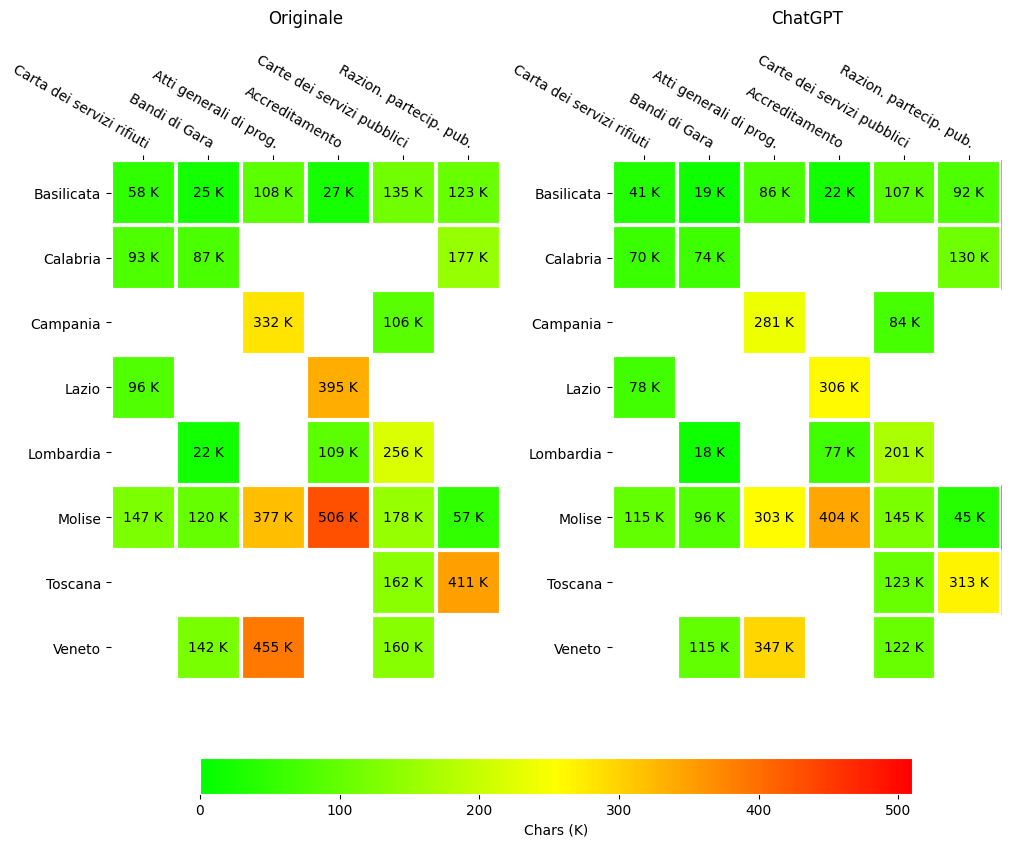

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharex='col', figsize=(10, 15), constrained_layout=True)

heatmap(chars_original, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[0], cmap="char_cmap", vmin=0, vmax=600, valfmt="{x:.0f} K")
heatmap(chars_oracle, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[1], cmap="char_cmap", vmin=0, vmax=600, valfmt="{x:.0f} K")
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=510), cmap='char_cmap'), ax=axs, shrink=0.8, location='bottom', orientation='horizontal', label="Chars (K)")

# Plot Titles titles
axs[0].set_title(f"Originale\n")
axs[1].set_title(f"ChatGPT\n")

plt.show()

## Tokens - heatmap

In [11]:
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Red to Green
mpl.colormaps.unregister('token_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('token_cmap', colors, N=256))

tokens_original = parse_heatmap_data(processed_df, 'tokens', 'original', lambda x: x.sum() // 1000 if x.sum() > 0 else np.nan)
tokens_oracle = parse_heatmap_data(processed_df, 'tokens', 'oracle', lambda x: x.sum() // 1000 if x.sum() > 0 else np.nan)

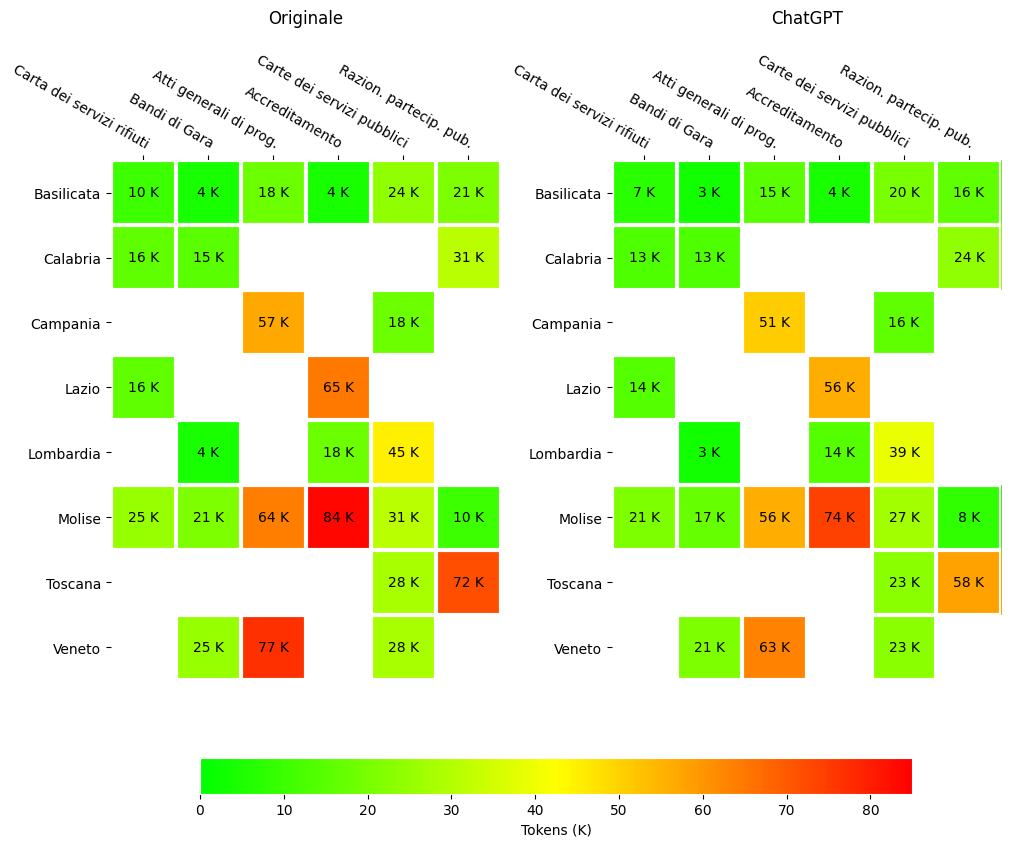

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharex='col', figsize=(10, 15), constrained_layout=True)

heatmap(tokens_original, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[0], cmap="token_cmap", vmin=0, vmax=85, valfmt="{x:.0f} K")
heatmap(tokens_oracle, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[1], cmap="token_cmap", vmin=0, vmax=85, valfmt="{x:.0f} K")
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=85), cmap='token_cmap'), ax=axs, shrink=0.8, location='bottom', orientation='horizontal', label="Tokens (K)")

# Plot Titles titles
axs[0].set_title(f"Originale\n")
axs[1].set_title(f"ChatGPT\n")

plt.show()

## VdB - heatmap

In [13]:
vdb_colors = [
  (1, 0, 0),
  (0.66, 0.33, 0),
  (0.33, 0.66, 0),
  (0, 1, 0)
]
mpl.colormaps.unregister('vdb_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('vdb_cmap', vdb_colors, N=5))

vdb_original = parse_heatmap_data(processed_df, '%_vdb', 'original', lambda x: x.mean() * 100)
vdb_oracle = parse_heatmap_data(processed_df, '%_vdb', 'oracle', lambda x: x.mean() * 100)

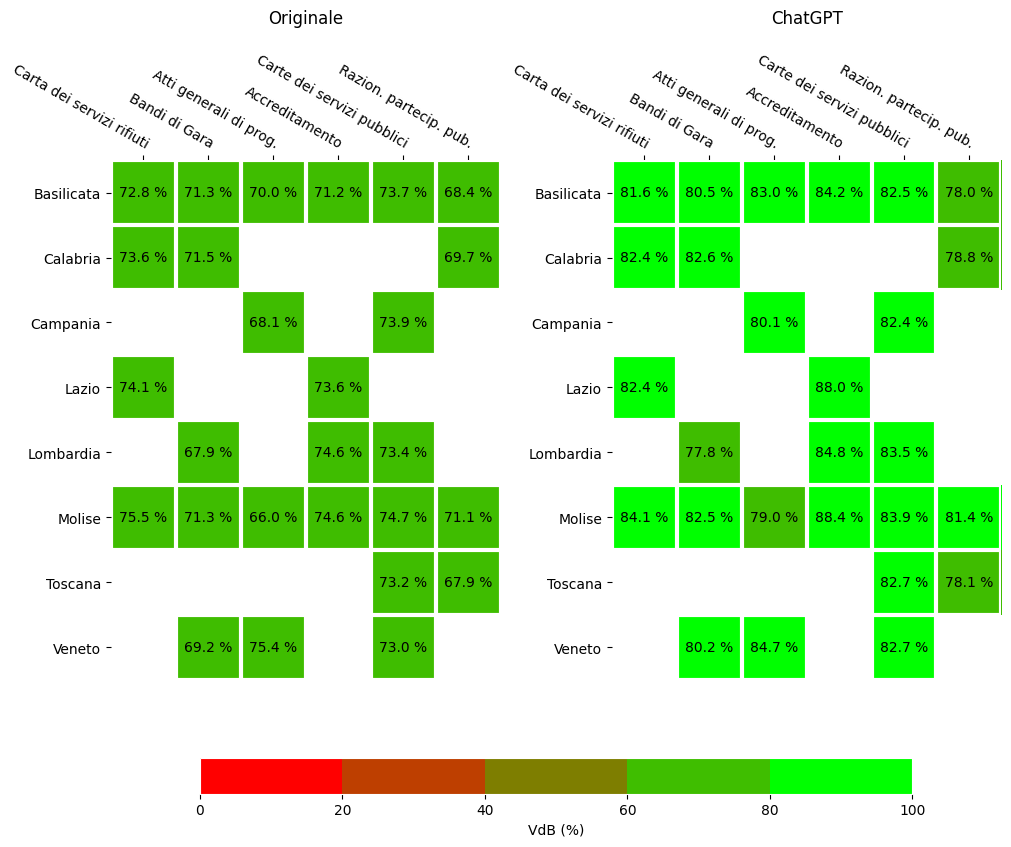

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharex='col', figsize=(10, 15), constrained_layout=True)

heatmap(vdb_original, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[0], cmap="vdb_cmap", vmin=0, vmax=100, valfmt="{x:.1f} %")
heatmap(vdb_oracle, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[1], cmap="vdb_cmap", vmin=0, vmax=100, valfmt="{x:.1f} %")
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=100), cmap='vdb_cmap'), ax=axs, shrink=0.8, location='bottom', orientation='horizontal', label="VdB (%)")

# Plot Titles titles
axs[0].set_title(f"Originale\n")
axs[1].set_title(f"ChatGPT\n")

plt.show()

## VdB - hist

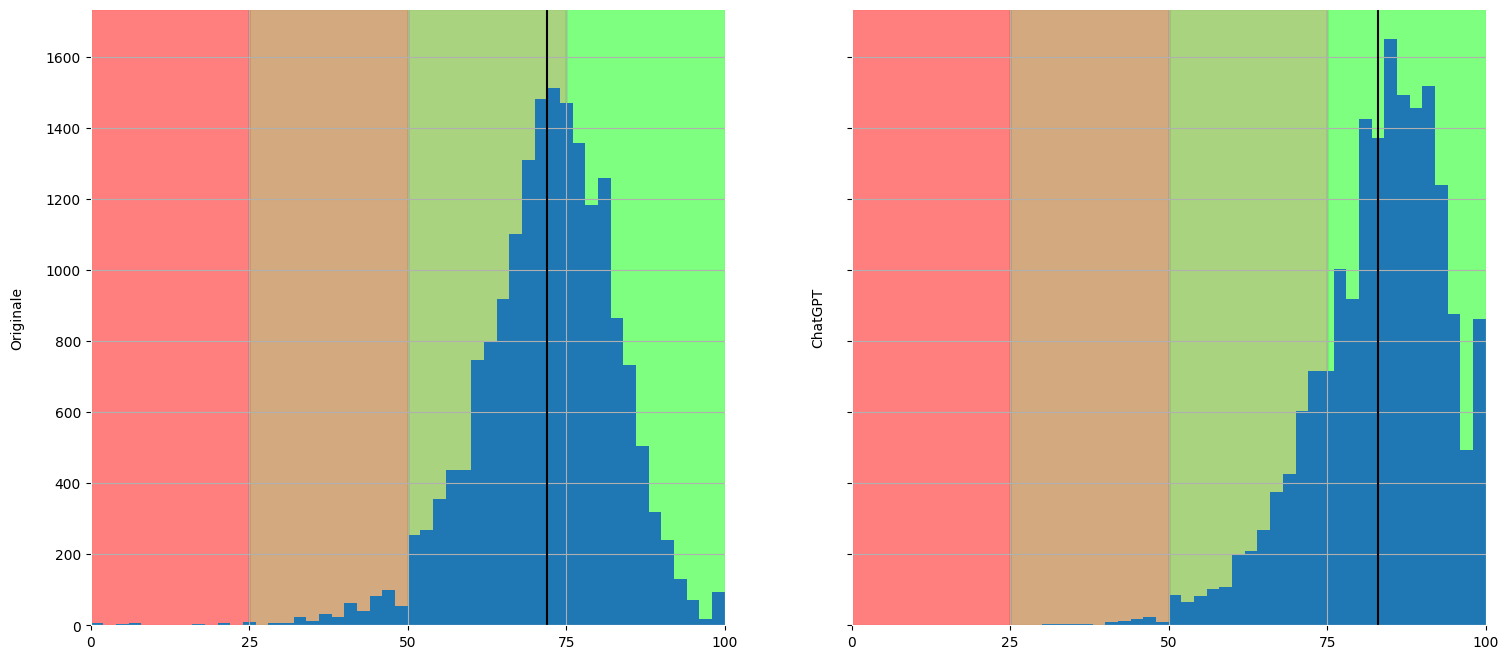

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharey='row', figsize=(18,8))

# Config -- perc vdb
for ax in [axs[0], axs[1]]:
  # Background
  ax.axvspan(0, 25, color=(1, 0, 0), alpha=0.5, label='Very Hard')
  ax.axvspan(25, 50, color=(0.66, 0.33, 0), alpha=0.5, label='Medium')
  ax.axvspan(50, 75, color=(0.33, 0.66, 0), alpha=0.5, label='Easy')
  ax.axvspan(75, 100, color=(0, 1, 0), alpha=0.5, label='Very Easy')

  # Plot limit
  ax.set_xlim(0, 100)

  # Tick
  ax.set_xticks([0, 25, 50, 75, 100])

# Hists
axs[0].hist(processed_df['%_vdb_original_text'] * 100, bins=50, range=(0, 100))
axs[1].hist(processed_df['%_vdb_oracle_text'] * 100, bins=50, range=(0, 100))

# Average
axs[0].axvline(x=processed_df['%_vdb_original_text'].mean() * 100, color='black', linestyle='-',label='mean')
axs[1].axvline(x=processed_df['%_vdb_oracle_text'].mean() * 100, color='black', linestyle='-',label='mean')

# Text titles
axs[0].set_ylabel(f"Originale\n")
axs[1].set_ylabel(f"ChatGPT\n")

plt.show()

## Gulpease

<center>

![gulpease.png](https://www.okpedia.it/data/okpedia/scala-di-gulpease.gif)

</center>

\begin{align}
89 + \frac{300 \cdot total\_sentences- 10 \cdot total\_characters}{total\_words}
\end{align}

## Gulpease - heatmap

In [16]:
gulpease_index_colors = [
  (1, 0, 0),
  (1, 0, 0),
  (1, 0, 0),
  (1, 0, 0),
  (0.66, 0.33, 0),
  (0.66, 0.33, 0),
  (0.33, 0.66, 0),
  (0.33, 0.66, 0),
  (0, 1, 0),
  (0, 1, 0)
]
mpl.colormaps.unregister('gulpease_index_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('gulpease_index_cmap', gulpease_index_colors, N=10))

gulpease_index_original = parse_heatmap_data(processed_df, 'gulpease_index', 'original', lambda x: x.mean() if x.mean() > 0 else np.nan)
gulpease_index_oracle = parse_heatmap_data(processed_df, 'gulpease_index', 'oracle', lambda x: x.mean() if x.mean() > 0 else np.nan)

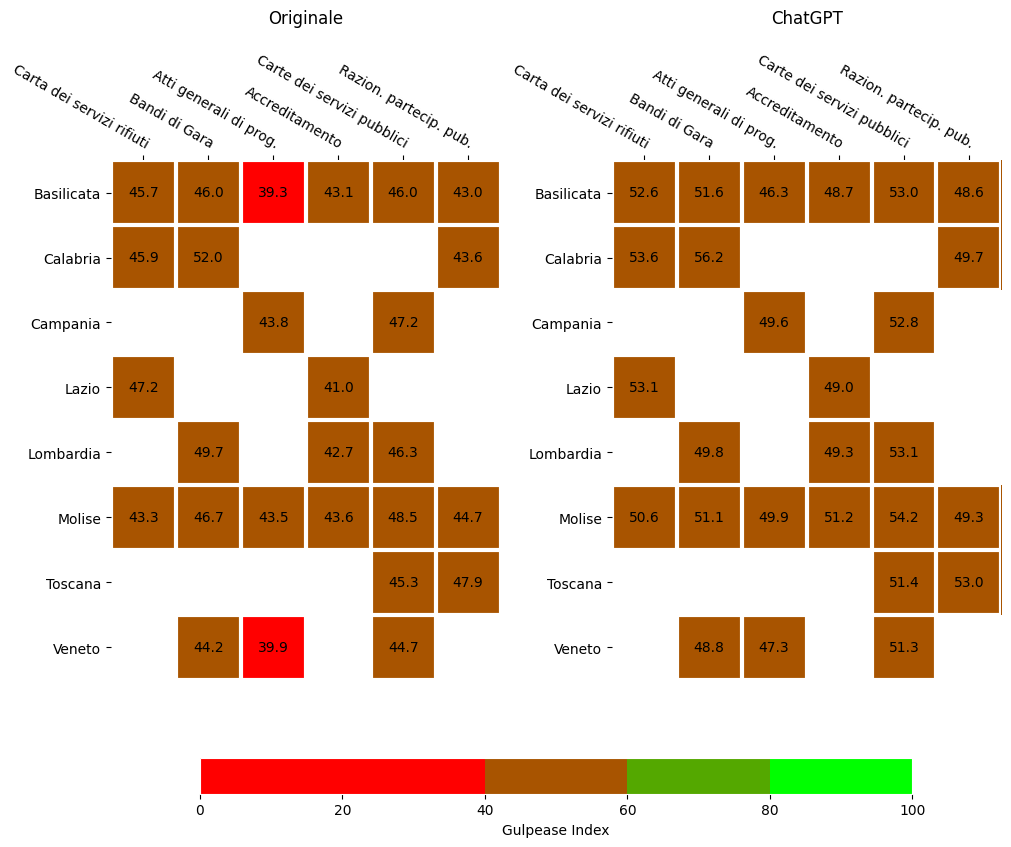

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharex='col', figsize=(10, 15), constrained_layout=True)

heatmap(gulpease_index_original, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[0], cmap="gulpease_index_cmap", vmin=0, vmax=100, valfmt="{x:.1f}")
heatmap(gulpease_index_oracle, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs[1], cmap="gulpease_index_cmap", vmin=0, vmax=100, valfmt="{x:.1f}")
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=100), cmap='gulpease_index_cmap'), ax=axs, shrink=0.8, location='bottom', orientation='horizontal', label="Gulpease Index")

# Plot Titles titles
axs[0].set_title(f"Originale\n")
axs[1].set_title(f"ChatGPT\n")

plt.show()

## Gulpease - hist

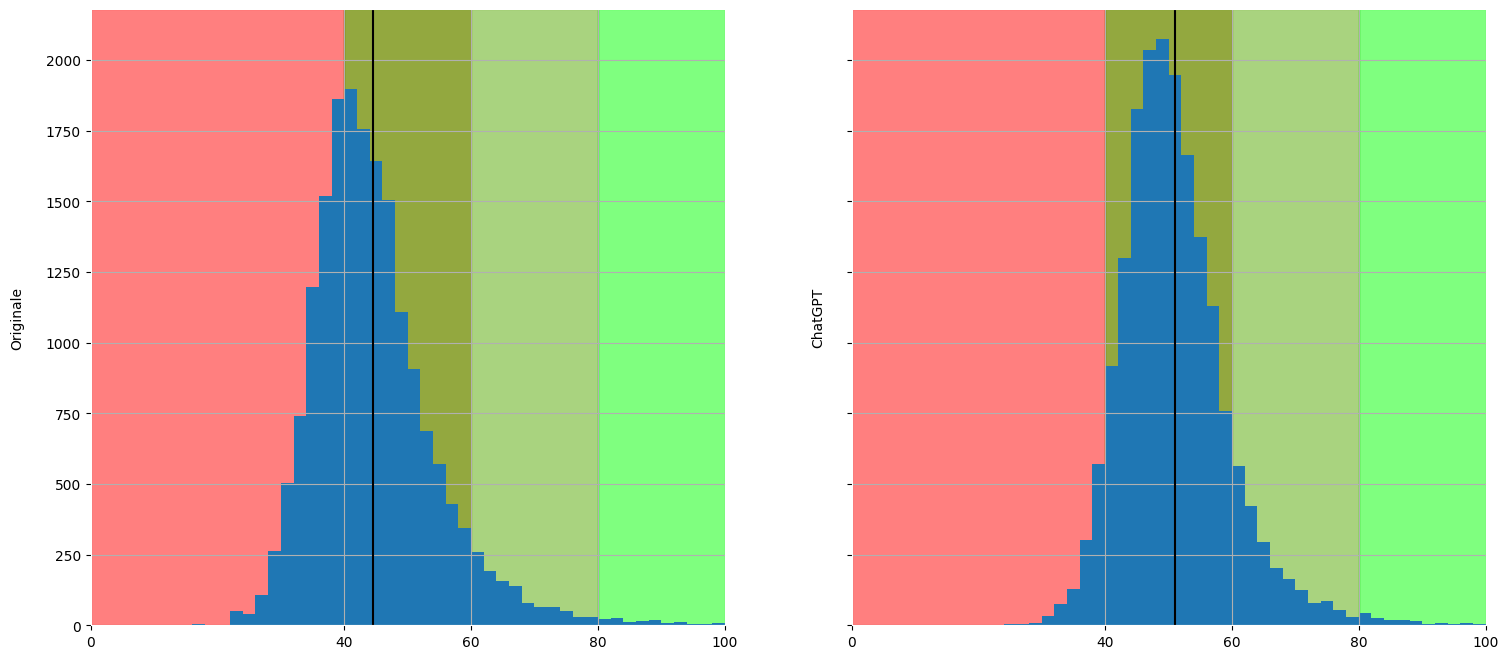

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharey='row', figsize=(18,8))

# Config -- gulpease_index
for ax in [axs[0], axs[1]]:
  # Background
  ax.axvspan(0, 40, color=(1, 0, 0), alpha=0.5, label='Hard')
  ax.axvspan(40, 60, color=(0.66, 0.33, 0), alpha=0.5, label='High school')
  ax.axvspan(40, 80, color=(0.33, 0.66, 0), alpha=0.5, label='Middle school')
  ax.axvspan(80, 100, color=(0, 1, 0), alpha=0.5, label='Elementary school')

  # Plot limit
  ax.set_xlim(0, 100)

  # Tick
  ax.set_xticks([0, 40, 60, 80, 100])

# Hists
axs[0].hist(processed_df['gulpease_index_original_text'], bins=50, range=(0, 100))
axs[1].hist(processed_df['gulpease_index_oracle_text'], bins=50, range=(0, 100))

# Average
axs[0].axvline(x=processed_df['gulpease_index_original_text'].mean(), color='black', linestyle='-',label='mean')
axs[1].axvline(x=processed_df['gulpease_index_oracle_text'].mean(), color='black', linestyle='-',label='mean')

# Text titles
axs[0].set_ylabel(f"Originale\n")
axs[1].set_ylabel(f"ChatGPT\n")

plt.show()

## Semantic Similarity - heatmap

In [24]:
semantic_similarity_colors = [
  (1, 0, 0),
  (0.66, 0.33, 0),
  (0.33, 0.66, 0),
  (0, 1, 0)
]
mpl.colormaps.unregister('semantic_similarity_cmap')
mpl.colormaps.register(matplotlib.colors.LinearSegmentedColormap.from_list('semantic_similarity_cmap', vdb_colors, N=5))

semantic_similarity = parse_heatmap_data(processed_df, 'semantic_similarity', 'original_vs_oracle', lambda x: x.mean())

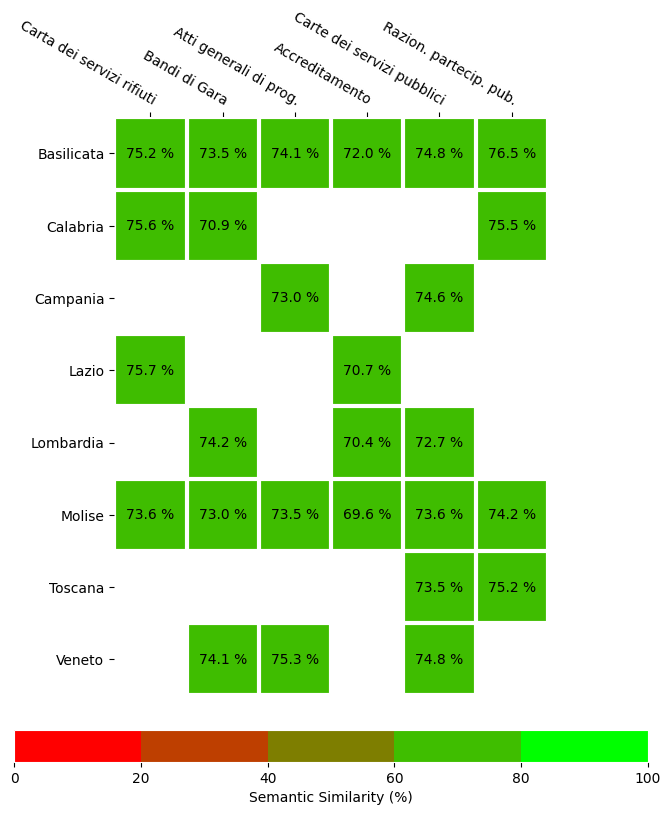

In [25]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(8, 8), constrained_layout=True)

heatmap(semantic_similarity, REGIONS_MAP.keys(), DOCUMENT_MAP.keys(), axs, cmap="semantic_similarity_cmap", vmin=0, vmax=100, valfmt="{x:.1f} %")
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=100), cmap='semantic_similarity_cmap'), ax=axs, shrink=0.8, location='bottom', orientation='horizontal', label="Semantic Similarity (%)")

plt.show()

## Semantic Similarity - hist

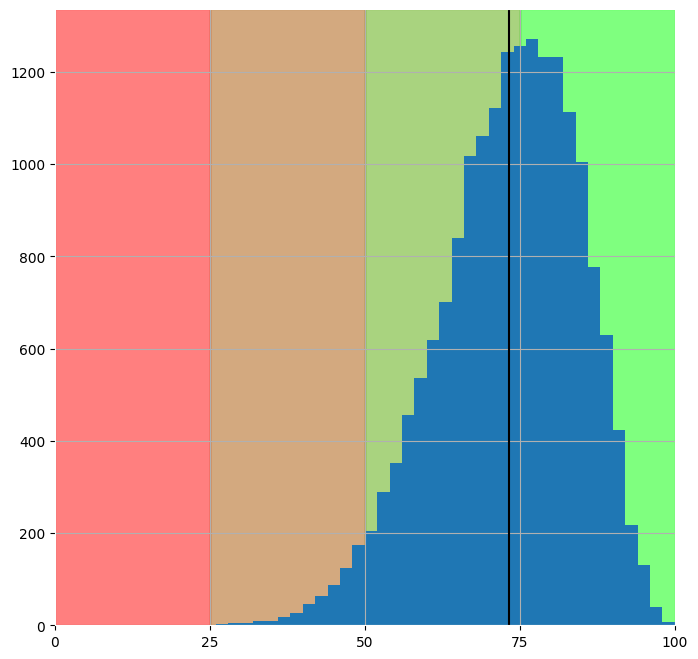

In [26]:
fig, axs = plt.subplots(1, 1, sharey='row', figsize=(8,8))

# Background
axs.axvspan(0, 25, color=(1, 0, 0), alpha=0.5, label='Very Hard')
axs.axvspan(25, 50, color=(0.66, 0.33, 0), alpha=0.5, label='Medium')
axs.axvspan(50, 75, color=(0.33, 0.66, 0), alpha=0.5, label='Easy')
axs.axvspan(75, 100, color=(0, 1, 0), alpha=0.5, label='Very Easy')

# Plot limit
axs.set_xlim(0, 100)

# Tick
axs.set_xticks([0, 25, 50, 75, 100])

# Plot
axs.hist(processed_df['semantic_similarity_original_vs_oracle_text'], bins=50, range=(0, 100))

axs.axvline(x=processed_df['semantic_similarity_original_vs_oracle_text'].mean(), color='black', linestyle='-',label='mean')

plt.show()